# Revenue Management Case Interview
This notebook performs revenue studies for Wells:
1. Provide a customer overview / situation assessment, what overall trends do you observe and what are the implications for Wells?
    1. What are the key Revenue Management KPIs that you would recommend Wells regularly reviews?
1. Assess Blue Bunny’s promotional strategy, what adjustments would you recommend? Why?
1. What would you recommend as the most efficient way to drive Blue Bunny sales volume? Why?
1. Do you see the opportunity to introduce or rationalize any package sizes?
1. Which items are the most price elastic? Which items are the least price elastic?
1. Should we increase price for Blue Bunny Scround? Supposedly we want to increase the price of Blue Bunny scrounds by 10%, what is the impact to unit sales, revenue and gross margin dollar? What are your recommendations based on the information you have?
1. How other brands or packages interact with Blue Bunny packaged ice cream? What recommendations do you have?
1. How do we use the competitor information and who should we benchmark against?
1. Please forecast future year sales volume, please explain your method and accuracy. 

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import xgboost as xgb

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

pd.set_option("display.float_format", "{:.2f}".format)

## EDA

In [3]:
file_path = './Case Data v 2.xlsx'

mapping = pd.read_excel(file_path, sheet_name=2)
mapping.columns = mapping.columns.str.lower().str.replace(" ", "_")
mapping["per"] = pd.to_datetime(mapping["per"].str.replace("WEEK ENDING ", ""), errors="coerce")
mapping = mapping.drop(columns=["per.1"])
mapping.rename(columns={"per": "day", "week_no": "week"}, inplace=True)

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_7620/1801972271.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mapping["per"] = pd.to_datetime(mapping["per"].str.replace("WEEK ENDING ", ""), errors="coerce")


## Q1 - Q5

### Sales data
- Trend Analysis: Aggregate and analyze total sales units and sales dollars over time to identify growth or decline.
- Baseline vs. Incremental Sales: Compare baseline sales and incremental volume to understand promotional impact.
- Promo vs. Non-Promo Sales: Evaluate the proportion of sales happening with promotions and its effectiveness.

In [4]:
sales = pd.read_excel(file_path, skiprows=6)
sales.columns = [
    "row_label", 
    "sales_2012", "sales_2013", "sales_2014", "sales_2015",
    "baseline_2012", "baseline_2013", "baseline_2014", "baseline_2015",
    "no_promo_2012", "no_promo_2013", "no_promo_2014", "no_promo_2015",
    "promo_2012", "promo_2013", "promo_2014", "promo_2015",
    "total_sales", "total_baseline", "total_no_promo", "total_promo"
]
sales = sales.drop(columns=["total_sales", "total_baseline", "total_no_promo", "total_promo"])
sales = sales[~sales["row_label"].astype(str).str.contains("Grand Total", na=False)].reset_index(drop=True)
sales.iloc[:, 1:] = sales.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Reshape data from wide to long format for easier analysis
sales_melted = sales.melt(id_vars=["row_label"], var_name="metric_year", value_name="value")
sales_melted[['metric', 'year']] = sales_melted["metric_year"].str.extract(r"(\D+)_(\d+)")
sales_melted["year"] = sales_melted["year"].astype(int)
sales_melted = sales_melted.drop(columns=["metric_year"]).dropna()

sales_pivoted = sales_melted.pivot_table(index=["row_label", "year"], columns="metric", values="value", aggfunc="sum").reset_index()
sales_pivoted.columns.name = None
sales_pivoted[["baseline", "no_promo", "promo", "sales"]] = sales_pivoted[["baseline", "no_promo", "promo", "sales"]].astype(int)
sales_pivoted = sales_pivoted[["row_label", "year", "sales", "baseline", "no_promo", "promo"]]
sales_pivoted.rename(columns={"row_label": "week"}, inplace=True)
sales_pivoted = sales_pivoted.merge(mapping, on=["year", "week"], how="left")
sales_pivoted = sales_pivoted.sort_values(by="day")
sales_pivoted

week  year  sales  baseline  no_promo  promo        day
87    30  2012   2345       964        53   2291 2012-07-28
90    31  2012   1245       856       653    590 2012-08-04
93    32  2012   1022       882       276    746 2012-08-11
96    33  2012   1026       881       990     36 2012-08-18
99    34  2012   2535       895        74   2461 2012-08-25
..   ...   ...    ...       ...       ...    ...        ...
74    25  2015   1696       891       140   1556 2015-06-20
77    26  2015    936       963       920     15 2015-06-27
80    27  2015  11529       899         0  11529 2015-07-04
83    28  2015   2525       896        42   2482 2015-07-11
86    29  2015   1384      1089       150   1233 2015-07-18

[156 rows x 7 columns]

In [5]:
fig = px.line(
    sales_pivoted, x="day", y=["baseline", "sales", "no_promo", "promo"],
    title="Sales Trend Over Time",
    labels={"day": "Date", "value": "Total Units Sold", "variable": "Metric"},
    markers=True
)
fig.update_layout(
    width=1200,  # Set width
    height=500  # Set height
)
fig.show()
# py.plot(fig, filename="wells_sales_trend_over_time", auto_open=True)

In [6]:
plotly_colors = px.colors.qualitative.Plotly  # Uses Plotly's default color sequence

fig = make_subplots(
    rows=2, cols=2, 
    subplot_titles=["Sales", "Baseline", "Promo", "No Promo"],
    vertical_spacing=0.1, horizontal_spacing=0.07  # Reduce whitespace
)

metrics = ["sales", "baseline", "promo", "no_promo"]
positions = [(1, 1), (1, 2), (2, 1), (2, 2)]  # Assign subplot positions

years = sorted(sales_pivoted["year"].unique())
year_color_map = {year: plotly_colors[i % len(plotly_colors)] for i, year in enumerate(years)}

for (metric, pos) in zip(metrics, positions):
    row, col = pos
    for year in years:
        subset = sales_pivoted[sales_pivoted["year"] == year]
        fig.add_trace(
            go.Scatter(
                x=subset["week"], y=subset[metric],
                mode="lines+markers",
                name=str(year) if metric == "sales" else None,  # Legend appears only once
                line=dict(color=year_color_map[year]),  # Apply consistent Plotly default colors
                marker=dict(color=year_color_map[year]),
                showlegend=(metric == "sales")  # Show legend only in first plot
            ),
            row=row, col=col
        )

fig.update_layout(
    title="Sales Units Overlaid by Year to Visualize Seasonality",
    height=600, width=1100,  # Adjust figure size
    showlegend=True,
    legend_title="Year",
    legend_traceorder="grouped",  # Ensure proper legend ordering
    margin=dict(l=40, r=40, t=60, b=40)  # Adjust margins to fit well
)

fig.show()
# py.plot(fig, filename="wells_sales_unit_overlaid_by_year", auto_open=True)

### SKU data

In [5]:
sku_all = pd.read_excel(file_path, sheet_name=1) # second sheet
sku_all.columns = sku_all.columns.str.lower().str.replace(" ", "_")
numeric_cols = [
    "week", "year", "sales_units", "sales_dollars", "total_baseline-units",
    "total_baseline-dollars", "no_promo_units", "no_promo_$", 
    "any_promo_units", "any_promo_$", "%acv-avg_distribution",
    "total_points_of_distribution", "avg_#_of_items_carried",
    "dollar_sales_per_mm_acv"
]
sku_all[numeric_cols] = sku_all[numeric_cols].apply(pd.to_numeric, errors='coerce')
sku_all["week_ending"] = pd.to_datetime(sku_all["per"].str.replace("WEEK ENDING ", ""), errors="coerce")
sku_all = sku_all.drop(columns=["per"])

sku_wells = sku_all[sku_all["wells_key_manufacturer(c)"] == "WELLS"]

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_7620/2626938732.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sku_all["week_ending"] = pd.to_datetime(sku_all["per"].str.replace("WEEK ENDING ", ""), errors="coerce")


In [8]:
market_trend = sku_all.groupby("week_ending")["sales_dollars"].sum().reset_index()
total_sales_by_manufacturer = sku_all.groupby("wells_key_manufacturer(c)")["sales_dollars"].sum().reset_index()
major_competitors = total_sales_by_manufacturer.sort_values(by="sales_dollars", ascending=False).head(5)["wells_key_manufacturer(c)"].tolist()

brand_weekly_sales = sku_all.groupby(["week_ending", "wells_key_manufacturer(c)"])["sales_dollars"].sum().unstack(fill_value=0).reset_index()
brand_weekly_sales["OTHER"] = brand_weekly_sales.drop(columns=["week_ending"] + major_competitors).sum(axis=1)
brand_weekly_sales = brand_weekly_sales[["week_ending"] + major_competitors + ["OTHER"]]

market_trend_melted = brand_weekly_sales.melt(id_vars=["week_ending"], 
                                              var_name="Manufacturer", 
                                              value_name="Sales ($)")

custom_order = ["WELLS"] + [m for m in major_competitors if m != "WELLS"] + ["OTHER"]
market_trend_melted["Manufacturer"] = pd.Categorical(
    market_trend_melted["Manufacturer"], 
    categories=custom_order, 
    ordered=True
)

fig = px.area(
    market_trend_melted,
    x="week_ending",
    y="Sales ($)",
    color="Manufacturer",
    title="Total Market Sales Breakdown by Manufacturer Over Time",
    labels={"week_ending": "Week Ending", "Sales ($)": "Total Sales ($)"},
    category_orders={"Manufacturer": custom_order}  # Ensures Wells is at the bottom
)

fig.update_layout(width=1200, height=500)
fig.show()
# py.plot(fig, filename="wells_market_share_revenue", auto_open=True)

# Ratio
total_weekly_sales = brand_weekly_sales.drop(columns=["week_ending"]).sum(axis=1)
brand_weekly_sales_ratio = brand_weekly_sales.copy()
for col in major_competitors + ["OTHER"]:
    brand_weekly_sales_ratio[col] = brand_weekly_sales[col] / total_weekly_sales

market_trend_melted = brand_weekly_sales_ratio.melt(id_vars=["week_ending"], 
                                                var_name="Manufacturer", 
                                                value_name="Sales Ratio")

fig = px.line(
    market_trend_melted,
    x="week_ending",
    y="Sales Ratio",
    color="Manufacturer",
    title="Sales Ratio by Manufacturer Over Time",
    labels={"week_ending": "Week Ending", "Sales Ratio": "Sales as % of Total Market"},
    category_orders={"Manufacturer": custom_order}
)

fig.update_layout(
    width=1200, height=500,
    yaxis=dict(tickformat=".1%")
)
fig.show()
# py.plot(fig, filename="wells_market_share_revenue_ratio", auto_open=True)

In [9]:
brand_weekly_units = sku_all.groupby(["week_ending", "wells_key_manufacturer(c)"])["sales_units"].sum().unstack(fill_value=0).reset_index()
brand_weekly_units["OTHER"] = brand_weekly_units.drop(columns=["week_ending"] + major_competitors).sum(axis=1)
brand_weekly_units = brand_weekly_units[["week_ending"] + major_competitors + ["OTHER"]]

market_trend_units_melted = brand_weekly_units.melt(id_vars=["week_ending"], 
                                                     var_name="Manufacturer", 
                                                     value_name="Sales Units")

market_trend_units_melted["Manufacturer"] = pd.Categorical(
    market_trend_units_melted["Manufacturer"], 
    categories=custom_order, 
    ordered=True
)

fig_units = px.area(
    market_trend_units_melted,
    x="week_ending",
    y="Sales Units",
    color="Manufacturer",
    title="Total Units Sold Breakdown by Manufacturer Over Time",
    labels={"week_ending": "Week Ending", "Sales Units": "Total Sales Units"},
    category_orders={"Manufacturer": custom_order}
)

fig_units.update_layout(width=1200, height=500)
fig_units.show()
# py.plot(fig_units, filename="wells_market_share_units", auto_open=True)


# Ratio
total_weekly_units = brand_weekly_units.drop(columns=["week_ending"]).sum(axis=1)
brand_weekly_units_ratio = brand_weekly_units.copy()
for col in major_competitors + ["OTHER"]:
    brand_weekly_units_ratio[col] = brand_weekly_units[col] / total_weekly_units

market_trend_melted = brand_weekly_units_ratio.melt(id_vars=["week_ending"], 
                                                var_name="Manufacturer", 
                                                value_name="Units Ratio")

fig = px.line(
    market_trend_melted,
    x="week_ending",
    y="Units Ratio",
    color="Manufacturer",
    title="Units Ratio by Manufacturer Over Time",
    labels={"week_ending": "Week Ending", "Sales Ratio": "Sales as % of Total Market"},
    category_orders={"Manufacturer": custom_order}
)

fig.update_layout(
    width=1200, height=500,
    yaxis=dict(tickformat=".1%")
)
fig.show()
# py.plot(fig, filename="wells_market_share_units_ratio", auto_open=True)

In [33]:
package_manufacturer_sales = sku_all.groupby(["week_ending", "wells_key_manufacturer(c)", "wells_package_type(c)"])["sales_dollars"].sum().reset_index()

# For each package type, we will:
# 1. Identify major competitors within that package (top 4 + OTHER)
# 2. Recalculate weekly sales and share
# 3. Generate area and line plots

package_figures = {}

for package_type in sku_all["wells_package_type(c)"].unique():
    df_pkg = package_manufacturer_sales[package_manufacturer_sales["wells_package_type(c)"] == package_type]

    total_sales = df_pkg.groupby("wells_key_manufacturer(c)")["sales_dollars"].sum().reset_index()
    top_manufacturers = total_sales.sort_values(by="sales_dollars", ascending=False).head(5)["wells_key_manufacturer(c)"].tolist()

    weekly_sales = df_pkg.pivot_table(index="week_ending", columns="wells_key_manufacturer(c)", values="sales_dollars", fill_value=0).reset_index()

    weekly_sales["OTHER"] = weekly_sales.drop(columns=["week_ending"] + top_manufacturers).sum(axis=1)
    weekly_sales = weekly_sales[["week_ending"] + top_manufacturers + ["OTHER"]]

    melted_area = weekly_sales.melt(id_vars="week_ending", var_name="Manufacturer", value_name="Sales ($)")

    ordered = ["WELLS"] + [m for m in top_manufacturers if m != "WELLS"] + ["OTHER"]
    melted_area["Manufacturer"] = pd.Categorical(melted_area["Manufacturer"], categories=ordered, ordered=True)

    area_fig = px.area(
        melted_area,
        x="week_ending",
        y="Sales ($)",
        color="Manufacturer",
        title=f"Total Market Sales Breakdown for {package_type} by Manufacturer Over Time",
        labels={"week_ending": "Week Ending"},
        category_orders={"Manufacturer": ordered}
    )
    area_fig.update_layout(width=1200, height=500)
    area_fig.show()
    py.plot(area_fig, filename="wells_package_area_" + package_type, auto_open=True)

    total_weekly = weekly_sales.drop(columns="week_ending").sum(axis=1)
    sales_ratio = weekly_sales.copy()
    for col in top_manufacturers + ["OTHER"]:
        sales_ratio[col] = sales_ratio[col] / total_weekly

    melted_ratio = sales_ratio.melt(id_vars="week_ending", var_name="Manufacturer", value_name="Sales Ratio")
    melted_ratio["Manufacturer"] = pd.Categorical(melted_ratio["Manufacturer"], categories=ordered, ordered=True)

    line_fig = px.line(
        melted_ratio,
        x="week_ending",
        y="Sales Ratio",
        color="Manufacturer",
        title=f"Sales Ratio Over Time for {package_type} by Manufacturer",
        labels={"week_ending": "Week Ending", "Sales Ratio": "Sales as % of Total Market"},
        category_orders={"Manufacturer": ordered}
    )
    line_fig.update_layout(width=1200, height=500, yaxis=dict(tickformat=".1%"))
    line_fig.show()
    py.plot(line_fig, filename="wells_package_ratio_" + package_type, auto_open=True)


In [10]:
wells_kpis = sku_wells.groupby("week_ending").agg(
    sales_units=("sales_units", "sum"),
    sales_dollars=("sales_dollars", "sum"),
    baseline_units=("total_baseline-units", "sum"),
    baseline_dollars=("total_baseline-dollars", "sum"),
    no_promo_units=("no_promo_units", "sum"),
    no_promo_dollars=("no_promo_$", "sum"),
    promo_units=("any_promo_units", "sum"),
    promo_dollars=("any_promo_$", "sum"),
    avg_acv_distribution=("%acv-avg_distribution", "mean"),
    total_points_of_distribution=("total_points_of_distribution", "sum"),
).reset_index()

# Compute Price KPIs
wells_kpis["avg_price_per_unit"] = wells_kpis["sales_dollars"] / wells_kpis["sales_units"]
wells_kpis["avg_baseline_price"] = wells_kpis["baseline_dollars"] / wells_kpis["baseline_units"]
wells_kpis["avg_no_promo_price"] = wells_kpis["no_promo_dollars"] / wells_kpis["no_promo_units"]
wells_kpis["avg_promo_price"] = wells_kpis["promo_dollars"] / wells_kpis["promo_units"]
wells_kpis["promo_efficiency"] = wells_kpis["avg_promo_price"] / wells_kpis["avg_no_promo_price"]

# Compute Promotion Effectiveness KPIs
wells_kpis["promo_share_units"] = wells_kpis["promo_units"] / wells_kpis["sales_units"]
wells_kpis["promo_share_dollars"] = wells_kpis["promo_dollars"] / wells_kpis["sales_dollars"]
wells_kpis["incremental_volume"] = wells_kpis["sales_units"] - wells_kpis["baseline_units"]
wells_kpis["incremental_volume_pct"] = wells_kpis["incremental_volume"] / wells_kpis["baseline_units"]
wells_kpis["incremental_revenue"] = wells_kpis["sales_dollars"] - wells_kpis["baseline_dollars"]
wells_kpis["incremental_revenue_pct"] = wells_kpis["incremental_revenue"] / wells_kpis["baseline_dollars"]

# Compute Distribution KPIs (weighted averages)
wells_kpis["avg_acv_distribution"] = (sku_wells["%acv-avg_distribution"] * sku_wells["sales_dollars"]).sum() / sku_wells["sales_dollars"].sum()
wells_kpis["avg_items_carried"] = (sku_wells["avg_#_of_items_carried"] * sku_wells["total_points_of_distribution"]).sum() / sku_wells["total_points_of_distribution"].sum()
wells_kpis["dollar_sales_per_mm_acv"] = (sku_wells["dollar_sales_per_mm_acv"] * sku_wells["sales_dollars"]).sum() / sku_wells["sales_dollars"].sum()
wells_kpis["depth_of_distribution"] = wells_kpis["total_points_of_distribution"] / wells_kpis["avg_items_carried"]
wells_kpis

week_ending  sales_units  sales_dollars  baseline_units  baseline_dollars  \
0    2012-07-28         6638          19208            4205             12914   
1    2012-08-04         5411          16639            4055             12516   
2    2012-08-11        14087          36599            3907             12107   
3    2012-08-18         5387          16304            3378             11192   
4    2012-08-25         4853          16680            3158             11066   
..          ...          ...            ...             ...               ...   
151  2015-06-20        10394          32825            1730              8403   
152  2015-06-27         3016           9925            1950              9278   
153  2015-07-04        13395          45069            1855              8616   
154  2015-07-11         3994          15121            1913              8894   
155  2015-07-18         3750          13212            2414             11020   

     no_promo_units  no_promo_dollars  promo_units  promo_dollars  \
0              2765              3040         3872          16169   
1              3747              9598         1662           7041   
2              4970              8432         9117          28167   
3              4112             11733         1275           4573   
4              2360              6318         2493          10364   
..              ...               ...          ...            ...   
151             336              2405        10058          30420   
152            1137              7027         1877           2900   
153             870              1434        12525          43635   
154             394               955         3599          14167   
155             510              3333         3238           9875   

     avg_acv_distribution  ...  promo_efficiency  promo_share_units  \
0                   84.63  ...              3.80               0.58   
1                   84.63  ...              1.65               0.31   
2                   84.63  ...              1.82               0.65   
3                   84.63  ...              1.26               0.24   
4                   84.63  ...              1.55               0.51   
..                    ...  ...               ...                ...   
151                 84.63  ...              0.42               0.97   
152                 84.63  ...              0.25               0.62   
153                 84.63  ...              2.11               0.94   
154                 84.63  ...              1.62               0.90   
155                 84.63  ...              0.47               0.86   

     promo_share_dollars  incremental_volume  incremental_volume_pct  \
0                   0.84                2433                    0.58   
1                   0.42                1356                    0.33   
2                   0.77               10180                    2.61   
3                   0.28                2009                    0.59   
4                   0.62                1695                    0.54   
..                   ...                 ...                     ...   
151                 0.93                8664                    5.01   
152                 0.29                1066                    0.55   
153                 0.97               11540                    6.22   
154                 0.94                2081                    1.09   
155                 0.75                1336                    0.55   

     incremental_revenue  incremental_revenue_pct  avg_items_carried  \
0                   6294                     0.49               1.00   
1                   4123                     0.33               1.00   
2                  24492                     2.02               1.00   
3                   5112                     0.46               1.00   
4                   5614                     0.51               1.00   
..                   ...                      ...   

In [16]:
sku_blue_bunny = sku_all[sku_all["wells_key_brand(c)"] == "BLUE BUNNY"]
cost_data = {
    "SCROUND": 2.58,
    "PAILS": 4.04,
    "SQUARE": 1.02,
    "PINT": 1.19,
    "SINGLE SERVE CUPS": 0.45
}

blue_bunny_kpis = sku_blue_bunny.groupby(["week_ending", "wells_package_type(c)"]).agg(
    sales_units=("sales_units", "sum"),
    sales_dollars=("sales_dollars", "sum"),
    baseline_units=("total_baseline-units", "sum"),
    baseline_dollars=("total_baseline-dollars", "sum"),
    no_promo_units=("no_promo_units", "sum"),
    no_promo_dollars=("no_promo_$", "sum"),
    promo_units=("any_promo_units", "sum"),
    promo_dollars=("any_promo_$", "sum"),
    avg_acv_distribution=("%acv-avg_distribution", "mean"),
    total_points_of_distribution=("total_points_of_distribution", "sum"),
    avg_items_carried=("avg_#_of_items_carried", "sum"), 
    dollar_sales_per_mm_acv=("dollar_sales_per_mm_acv", "mean")
).reset_index()

# Compute Price KPIs
blue_bunny_kpis["avg_price_per_unit"] = blue_bunny_kpis["sales_dollars"] / blue_bunny_kpis["sales_units"]
blue_bunny_kpis["avg_baseline_price"] = blue_bunny_kpis["baseline_dollars"] / blue_bunny_kpis["baseline_units"]
blue_bunny_kpis["avg_no_promo_price"] = blue_bunny_kpis["no_promo_dollars"] / blue_bunny_kpis["no_promo_units"]
blue_bunny_kpis["avg_promo_price"] = blue_bunny_kpis["promo_dollars"] / blue_bunny_kpis["promo_units"]
blue_bunny_kpis["promo_efficiency"] = blue_bunny_kpis["avg_promo_price"] / blue_bunny_kpis["avg_no_promo_price"]

# Compute Profit Margins
blue_bunny_kpis["cost_per_unit"] = blue_bunny_kpis["wells_package_type(c)"].map(cost_data)
blue_bunny_kpis["profit_per_unit"] = blue_bunny_kpis["avg_price_per_unit"] - blue_bunny_kpis["cost_per_unit"]
blue_bunny_kpis["profit_gross"] = blue_bunny_kpis["profit_per_unit"] * blue_bunny_kpis["sales_units"]
blue_bunny_kpis["profit_margin"] = blue_bunny_kpis["profit_per_unit"] / blue_bunny_kpis["avg_price_per_unit"]

# Compute Promotion Effectiveness KPIs
blue_bunny_kpis["promo_share_units"] = blue_bunny_kpis["promo_units"] / blue_bunny_kpis["sales_units"]
blue_bunny_kpis["promo_share_dollars"] = blue_bunny_kpis["promo_dollars"] / blue_bunny_kpis["sales_dollars"]
blue_bunny_kpis["incremental_volume"] = blue_bunny_kpis["sales_units"] - blue_bunny_kpis["baseline_units"]
blue_bunny_kpis["incremental_volume_pct"] = blue_bunny_kpis["incremental_volume"] / blue_bunny_kpis["baseline_units"]
blue_bunny_kpis["incremental_revenue"] = blue_bunny_kpis["sales_dollars"] - blue_bunny_kpis["baseline_dollars"]
blue_bunny_kpis["incremental_revenue_pct"] = blue_bunny_kpis["incremental_revenue"] / blue_bunny_kpis["baseline_dollars"]

blue_bunny_kpis.describe()

week_ending  sales_units  sales_dollars  \
count                            655       655.00         655.00   
mean   2013-12-31 19:03:12.366412288      1264.69        4438.20   
min              2012-07-28 00:00:00        22.00          67.00   
25%              2013-03-16 00:00:00       243.50        1256.50   
50%              2013-12-28 00:00:00       741.00        1999.00   
75%              2014-10-07 12:00:00      1041.00        5182.00   
max              2015-07-18 00:00:00     11670.00       40855.00   
std                              NaN      2041.40        6826.10   

       baseline_units  baseline_dollars  no_promo_units  no_promo_dollars  \
count          655.00            655.00          655.00            655.00   
mean           526.90           2289.75          369.13           1525.24   
min             19.00             51.00            0.00              0.00   
25%            202.50           1091.00           42.00            151.50   
50%            401.00           1585.00          217.00           1136.00   
75%            828.00           2281.50          689.50           1814.00   
max           2499.00           7488.00         4366.00           9057.00   
std            372.21           1856.66          424.52           1760.07   

       promo_units  promo_dollars  avg_acv_distribution  ...  cost_per_unit  \
count       655.00         655.00                655.00  ...         655.00   
mean        895.41        2912.87                 65.79  ...           1.98   
min           0.00           0.00                 12.83  ...           0.45   
25%           0.00           0.00                 51.03  ...           1.02   
50%          46.00         182.00                 65.12  ...           1.19   
75%         556.50        2410.00                 83.96  ...           2.58   
max       11659.00       40816.00                100.00  ...           4.04   
std        2135.11        7128.09                 20.69  ...           1.38   

       profit_per_unit  profit_gross  profit_margin  promo_share_units  \
count           655.00        655.00         655.00             655.00   
mean              2.77       2199.72           0.60               0.37   
min               0.53         30.11           0.23               0.00   
25%               0.94        819.83           0.54               0.00   
50%               3.27       1180.48           0.58               0.09   
75%               3.90       2944.93           0.68               0.93   
max               4.96      18534.22           0.82               1.00   
std               1.44       2528.59           0.13               0.43   

       promo_share_dollars  incremental_volume  incremental_volume_pct  \
count               655.00              655.00                  655.00   
mean                  0.36              737.79                    1.61   
min                   0.00             -721.00                   -0.43   
25%                   0.00                9.00                    0.02   
50%                   0.08               78.00                    0.21   
75%                   0.93              300.00                    0.90   
max                   1.00            10755.00                   43.12   
std                   0.43             1936.45                    4.62   

       incremental_revenue  incremental_revenue_pct  
count               655.00                   655.00  
mean               2148.45                     1.01  
min               -1239.00                    -0.44  
25%                  23.00                     0.02  
50%                 287.00                     0.19  
75%                1267.50                     0.68  
max               35827.00                    25.50  
std                6024.02                     2.81  

[8 rows x 28 columns]

In [13]:
# Sales Units Over Time
fig = px.line(
    blue_bunny_kpis, 
    x="week_ending", 
    y="sales_units", 
    color="wells_package_type(c)", 
    title="Blue Bunny Sales Units Over Time by Package Type",
    labels={"sales_units": "Units Sold", "week_ending": "Week Ending"}
)
fig.update_layout(
    width=1200,  # Set width
    height=500  # Set height
)
fig.show()
# py.plot(fig, filename="bb_units_by_package", auto_open=True)

# Sales Dollars Over Time
fig = px.line(
    blue_bunny_kpis, 
    x="week_ending", 
    y="sales_dollars", 
    color="wells_package_type(c)", 
    title="Blue Bunny Sales Revenue Over Time by Package Type",
    labels={"sales_dollars": "Sales Revenue ($)", "week_ending": "Week Ending"}
)
fig.update_layout(
    width=1200,  # Set width
    height=500  # Set height
)
fig.show()
# py.plot(fig, filename="bb_revenue_by_package", auto_open=True)

# Average Price Per Unit Over Time
fig = px.line(
    blue_bunny_kpis, 
    x="week_ending", 
    y="avg_price_per_unit", 
    color="wells_package_type(c)", 
    title="Blue Bunny Average Price Per Unit Over Time by Package Type",
    labels={"avg_price_per_unit": "Average Price Per Unit ($)", "week_ending": "Week Ending"}
)
fig.update_layout(
    width=1200,  # Set width
    height=500  # Set height
)
fig.show()
# py.plot(fig, filename="bb_price_by_package", auto_open=True)

# Gross Profit Over Time
fig = px.line(
    blue_bunny_kpis, 
    x="week_ending", 
    y="profit_gross", 
    color="wells_package_type(c)", 
    title="Blue Bunny Gross Profit Over Time by Package Type",
    labels={"profit_gross": "Gross Profit ($)", "week_ending": "Week Ending"}
)
fig.update_layout(
    width=1200,  # Set width
    height=500  # Set height
)
fig.show()
# py.plot(fig, filename="bb_profit_gross_by_package", auto_open=True)


# Profit Per Unit Over Time
fig = px.line(
    blue_bunny_kpis, 
    x="week_ending", 
    y="profit_margin", 
    color="wells_package_type(c)", 
    title="Blue Bunny Profit Margin Over Time by Package Type",
    labels={"profit_margin": "Profit Margin (%)", "week_ending": "Week Ending"}
)
fig.update_layout(
    width=1200,  # Set width
    height=500  # Set height
)
fig.show()
# py.plot(fig, filename="bb_profit_by_package", auto_open=True)

# Average ACV Distribution Over Time
fig = px.line(
    blue_bunny_kpis, 
    x="week_ending", 
    y="avg_acv_distribution", 
    color="wells_package_type(c)", 
    title="Blue Bunny Average ACV Distribution Over Time by Package Type",
    labels={"avg_acv_distribution": "Average ACV Distribution (%)", "week_ending": "Week Ending"}
)
fig.update_layout(
    width=1200,  # Set width
    height=500  # Set height
)
fig.show()
# py.plot(fig, filename="bb_acv_by_package", auto_open=True)

In [ ]:
def plot_combined_dual_axis(metric_col, title):
    df = blue_bunny_kpis.copy()

    df[f"{metric_col}_rolling"] = df.groupby("wells_package_type(c)")[metric_col].transform(lambda x: x.rolling(window=52, min_periods=4).mean())
    df[f"{metric_col}_yoy"] = df.groupby("wells_package_type(c)")[f"{metric_col}_rolling"].transform(lambda x: x.pct_change(periods=52))

    min_date = df["week_ending"].min()
    df = df[df["week_ending"] >= (min_date + pd.Timedelta(weeks=52))]

    package_types = df["wells_package_type(c)"].unique()

    fig = go.Figure()

    for i, package in enumerate(package_types):
        df_pkg = df[df["wells_package_type(c)"] == package]
        color = assigned_colors.get(package, None)

        # Add rolling average as a doted line (left y-axis)
        fig.add_trace(go.Scatter(
            x=df_pkg["week_ending"],
            y=df_pkg[f"{metric_col}_rolling"],
            mode="lines+markers",
            name=f"{package}",
            line=dict(color=color, dash="dot"),
            marker=dict(size=3),
            yaxis="y1"
        ))

        fig.add_trace(go.Scatter(
            x=df_pkg["week_ending"],
            y=df_pkg[f"{metric_col}_yoy"],
            mode="lines",
            name=f"{package} - YoY %",
            line=dict(color=color),
            yaxis="y2",
            showlegend=False
        ))

    fig.update_layout(
        title=title,
        xaxis_title="Week Ending",
        yaxis=dict(title="52W Average", showgrid=False),
        yaxis2=dict(title="YoY % Change", overlaying='y', side='right', tickformat=".0%", showgrid=False),
        width=1200,
        height=500,
        legend=dict(
            x=1.08,
            y=1,
            xanchor="left",
            yanchor="top",
            orientation="v",
        )
    )

    fig.show()
    py.plot(fig, filename="bb_" + metric_col + "52W Avg & YoY % Change", auto_open=True)

# Plot all three metrics
plot_combined_dual_axis("sales_units", "Blue Bunny Sales Units - 52W Avg & YoY % Change", "Sales Units")
plot_combined_dual_axis("sales_dollars", "Blue Bunny Sales Revenue - 52W Avg & YoY % Change", "Sales Revenue ($)")
plot_combined_dual_axis("profit_gross", "Blue Bunny Gross Profit - 52W Avg & YoY % Change", "Gross Profit ($)")


## Q5. Price Elasticity

In [17]:
sku_blue_bunny["unit_price"] = sku_blue_bunny["sales_dollars"] / sku_blue_bunny["sales_units"]

sku_blue_bunny = sku_blue_bunny.dropna(subset=["unit_price", "sales_units"])
sku_blue_bunny = sku_blue_bunny[(sku_blue_bunny["unit_price"] > 0) & (sku_blue_bunny["sales_units"] > 0)]

promo_data = sku_blue_bunny[sku_blue_bunny["any_promo_units"] > 0]
no_promo_data = sku_blue_bunny[sku_blue_bunny["no_promo_units"] > 0]
sku_blue_bunny["promo_status"] = sku_blue_bunny.apply(
    lambda row: "Promo" if row["any_promo_units"] > 0 else "No Promo" if row["no_promo_units"] > 0 else "Other",
    axis=1
)
combined_data = sku_blue_bunny[sku_blue_bunny["promo_status"].isin(["Promo", "No Promo"])]

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_918/3145772002.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
fig_ref = px.line(
    blue_bunny_kpis, 
    x="week_ending", 
    y="sales_units", 
    color="wells_package_type(c)", 
)
assigned_colors = {trace.name: trace.line.color for trace in fig_ref.data}

fig_promo = px.scatter(
    promo_data,
    x="unit_price",
    y="sales_units",
    color="wells_package_type(c)",
    title="Price Elasticity Analysis - Promo",
    labels={"unit_price": "Price per Unit ($)", "sales_units": "Sales Units"},
    trendline="ols",
    opacity=0.8,
    size_max=6,
    color_discrete_map=assigned_colors
)
fig_promo.update_layout(width=1200, height=500)
# py.plot(fig, filename="bb_elasticity_promo", auto_open=True)

fig_no_promo = px.scatter(
    no_promo_data,
    x="unit_price",
    y="sales_units",
    color="wells_package_type(c)",
    title="Price Elasticity Analysis - No Promo",
    labels={"unit_price": "Price per Unit ($)", "sales_units": "Sales Units"},
    trendline="ols",
    opacity=0.8,
    size_max=6,
    color_discrete_map=assigned_colors
)
fig_no_promo.update_layout(width=1200, height=500)
# py.plot(fig, filename="bb_elasticity_no_promo", auto_open=True)

symbol_map = {"Promo": "circle", "No Promo": "cross"}
fig_combined = px.scatter(
    combined_data,
    x="unit_price",
    y="sales_units",
    color="wells_package_type(c)",
    symbol="promo_status",
    title="Price Elasticity Analysis - Combined",
    labels={"unit_price": "Price per Unit ($)", "sales_units": "Sales Units"},
    size_max=6,
    color_discrete_map=assigned_colors, 
    symbol_map=symbol_map
)
for trace in fig_combined.data:
    if "No Promo" in trace.name:
        trace.marker.opacity = 0.3
    else:
        trace.marker.opacity = 0.8
fig_combined.update_layout(width=1200, height=500)
# py.plot(fig, filename="bb_elasticity_combined", auto_open=True)

fig_promo.show()
fig_no_promo.show()
fig_combined.show()

## Q6. Price Increase?

In [89]:
ols_results = []

for package_type, group in promo_data.groupby("wells_package_type(c)"):
    if len(group) > 1: 
        X = group["unit_price"]
        y = group["sales_units"]

        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()

        ols_results.append({
            "Package Type": package_type,
            "Slope": model.params["unit_price"],
            "Intercept": model.params["const"],
            "R-Squared": model.rsquared  # Add R² to evaluate fit
        })

ols_df = pd.DataFrame(ols_results).sort_values(by="Slope", ascending=True)
ols_df

Package Type   Slope  Intercept  R-Squared
3  SINGLE SERVE CUPS -650.01     960.54       0.51
4             SQUARE -117.92     578.50       0.35
2            SCROUND  -84.24     516.19       0.37
0              PAILS  -28.46     266.90       0.25
1               PINT   16.49     -16.46       0.06

In [ ]:
price_increase_pct = 0.10
cost_scround = cost_data["SCROUND"]

scround_slope = ols_df.loc[ols_df["Package Type"] == "SCROUND", "Slope"].values[0]
scround_intercept = ols_df.loc[ols_df["Package Type"] == "SCROUND", "Intercept"].values[0]

old_units_scround = sku_blue_bunny.loc[sku_blue_bunny["wells_package_type(c)"] == "SCROUND", "sales_units"].mean()
old_sales_scround = sku_blue_bunny.loc[sku_blue_bunny["wells_package_type(c)"] == "SCROUND", "sales_dollars"].mean()
old_price_scround = old_sales_scround / old_units_scround
old_profit_scround = (old_price_scround - cost_scround) * old_units_scround

new_price_scround = old_price_scround * (1 + price_increase_pct)
new_units_scround = old_units_scround + scround_slope * (new_price_scround - old_price_scround)
new_sales_scround = new_price_scround * new_units_scround
new_profit_scround = (new_price_scround - cost_scround) * new_units_scround

change_price_scround = price_increase_pct * 100
change_units_scround = ((new_units_scround - old_units_scround) / old_units_scround) * 100
change_sales_scround = ((new_sales_scround - old_sales_scround) / old_sales_scround) * 100
change_profit_scround = ((new_profit_scround - old_profit_scround) / old_profit_scround) * 100

results_df = pd.DataFrame(
    data={
        "Price": [old_price_scround, new_price_scround, change_price_scround],
        "Units": [old_units_scround, new_units_scround, change_units_scround],
        "Revenue": [old_sales_scround, new_sales_scround, change_sales_scround],
        "Gross Margin": [old_profit_scround, new_profit_scround, change_profit_scround],
    },
    index=["Old", "New", "Change %"]
)

results_df

Price  Units  Revenue  Gross Margin
Old        4.32  72.63   313.98        126.58
New        4.75  36.22   172.23         78.78
Change %  10.00 -50.13   -45.14        -37.76

In [ ]:
price_range = np.linspace(3, 6, 50)

predicted_units = scround_intercept + scround_slope * price_range
predicted_revenue = price_range * predicted_units
predicted_gross_margin = (price_range - cost_scround) * predicted_units

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=price_range,
    y=predicted_revenue,
    name="Revenue",
    mode="lines",
    yaxis="y1",
))

fig.add_trace(go.Scatter(
    x=price_range,
    y=predicted_gross_margin,
    name="Gross Margin",
    mode="lines",
    yaxis="y2",
))

fig.update_layout(
    title="Predicted Revenue & Gross Margin vs. Price for SCROUND",
    xaxis=dict(title="Price per Unit ($)", showgrid=True),
    yaxis=dict(title="Revenue ($)", side="left", showgrid=True),
    yaxis2=dict(title="Gross Margin ($)", side="right", overlaying="y", showgrid=False),
    legend=dict(title="Metric", x=0.5, y=0.1, xanchor="center", yanchor="bottom", orientation="v"),
    width=1200,
    height=500,
)

fig.show()
# py.plot(fig, filename="bb_scround_prediction", auto_open=True)

In [73]:
fig = px.box(
    blue_bunny_kpis, 
    x="wells_package_type(c)", 
    y="dollar_sales_per_mm_acv", 
    title="Benchmarking: Dollar Sales per MM ACV by Package Type",
    labels={"dollar_sales_per_mm_acv": "Dollar Sales per MM ACV"}
)
fig.update_layout(width=1200, height=500)
fig.show()

## Q7. Competitor

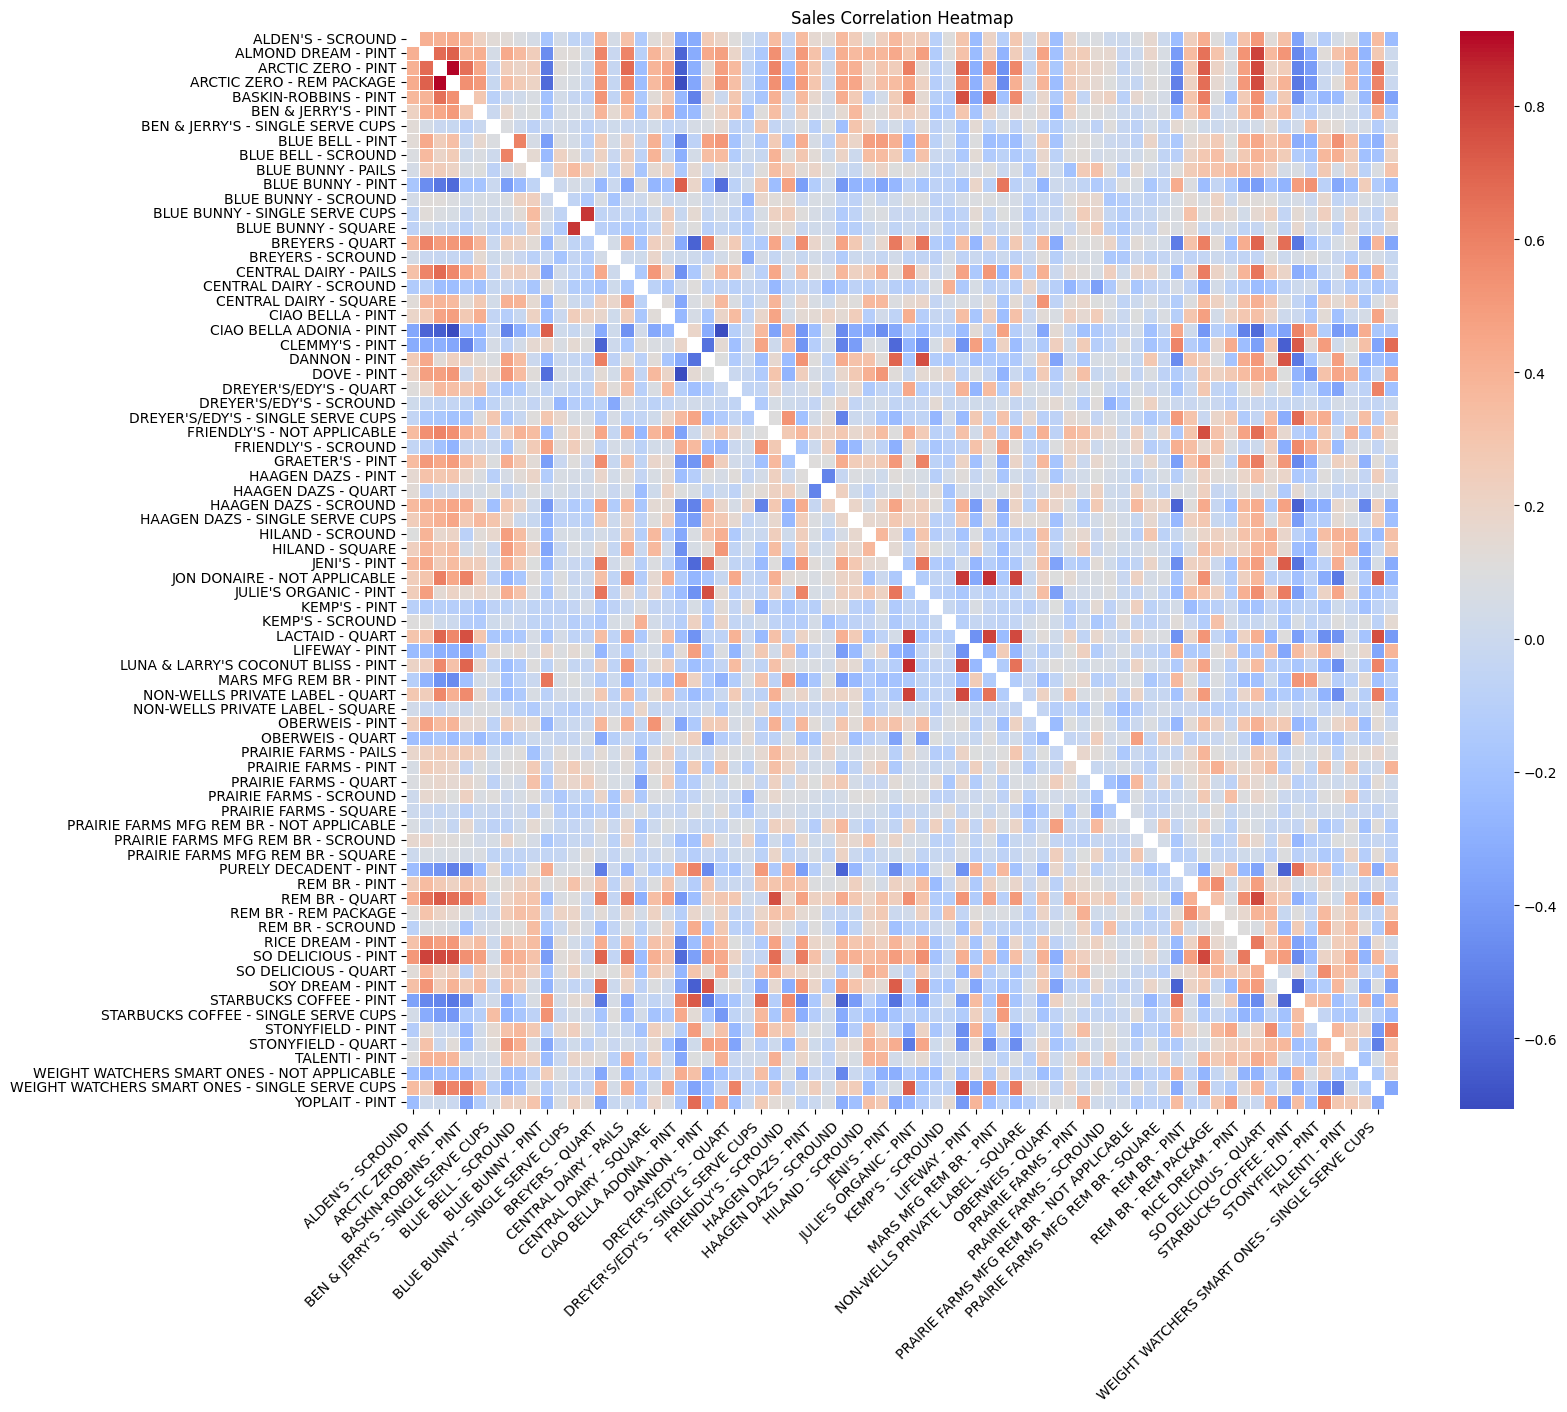

In [25]:
market_trend_grouped = sku_all.groupby(["week_ending", "wells_key_brand(c)", "wells_package_type(c)"])["sales_dollars"].sum().reset_index()

market_trend_pivot = market_trend_grouped.pivot_table(
    index="week_ending",
    columns=["wells_key_brand(c)", "wells_package_type(c)"],
    values="sales_dollars",
    aggfunc="sum"
).fillna(0)

market_trend_pivot.columns = [f"{brand} - {package}" for brand, package in market_trend_pivot.columns]

corr_matrix_sales = market_trend_pivot.corr()

mask = np.eye(corr_matrix_sales.shape[0], dtype=bool)

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix_sales, 
    annot=False,  # Remove annotations for readability
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    mask=mask  # Apply mask to hide diagonal
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Sales Correlation Heatmap")
plt.show()


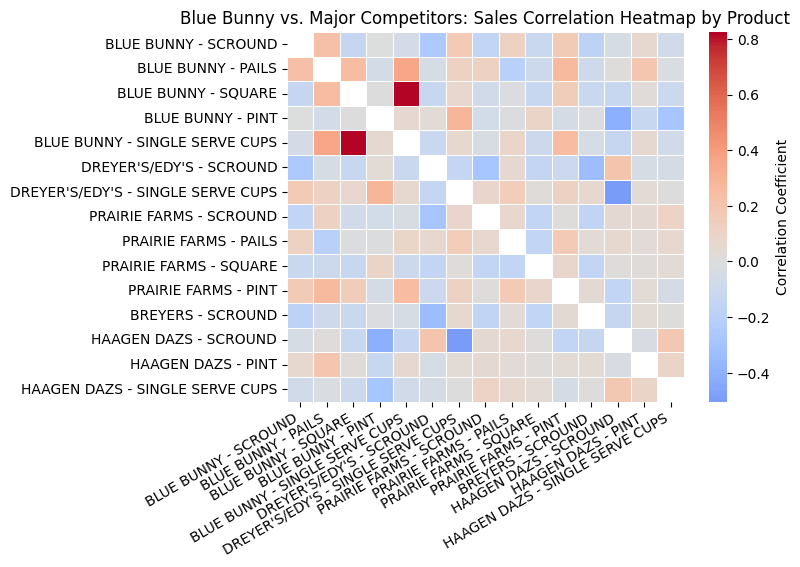

In [ ]:
brands = ["BLUE BUNNY", "DREYER'S/EDY'S", "PRAIRIE FARMS", "BREYERS", "HAAGEN DAZS"]
packages = ["SCROUND", "PAILS", "SQUARE", "PINT", "SINGLE SERVE CUPS"]
labels = [f"{brand} - {package}" for brand in brands for package in packages]
labels = [label for label in labels if label in market_trend_pivot.columns]

corr_matrix_filtered = market_trend_pivot.corr().loc[labels, labels]

mask = np.eye(corr_matrix_filtered.shape[0], dtype=bool)

np.fill_diagonal(corr_matrix_filtered.values, np.nan)

sns.heatmap(
    corr_matrix_filtered, 
    annot=False,  # Remove annotations for better readability
    cmap="coolwarm",  # Color map for correlation
    linewidths=0.5,
    center=0,  # Balance the color map around 0
    cbar_kws={"label": "Correlation Coefficient"}  # Label color bar
)

plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.title("Blue Bunny vs. Major Competitors: Sales Correlation Heatmap by Product")
plt.show()

In [ ]:
weekly_sales = sku_all.groupby(["week_ending", "wells_key_manufacturer(c)", "wells_package_type(c)"])["sales_dollars"].sum().reset_index()
weekly_units = sku_all.groupby(["week_ending", "wells_key_manufacturer(c)", "wells_package_type(c)"])["sales_units"].sum().reset_index()

weekly_df = pd.merge(weekly_sales, weekly_units, on=["week_ending", "wells_key_manufacturer(c)", "wells_package_type(c)"])
weekly_df["unit_price"] = weekly_df["sales_dollars"] / weekly_df["sales_units"]

for package_type in sku_all["wells_package_type(c)"].dropna().unique():
    df_pkg = weekly_df[weekly_df["wells_package_type(c)"] == package_type]

    total_sales = df_pkg.groupby("wells_key_manufacturer(c)")["sales_dollars"].sum().reset_index()
    top_manufacturers = total_sales.sort_values(by="sales_dollars", ascending=False).head(5)["wells_key_manufacturer(c)"].tolist()

    if "WELLS" not in top_manufacturers:
        continue

    wells_df = df_pkg[df_pkg["wells_key_manufacturer(c)"] == "WELLS"][["week_ending", "sales_units"]]

    merged_df = wells_df.copy()

    for comp in [m for m in top_manufacturers if m != "WELLS"]:
        comp_df = df_pkg[df_pkg["wells_key_manufacturer(c)"] == comp]
        comp_price = comp_df[["week_ending", "unit_price"]].rename(columns={"unit_price": f"{comp}_price"})
        merged_df = merged_df.merge(comp_price, on="week_ending", how="left")

    melted = merged_df.melt(
        id_vars=["week_ending", "sales_units"],
        value_vars=[f"{comp}_price" for comp in top_manufacturers if comp != "WELLS"],
        var_name="Competitor",
        value_name="Competitor Price"
    )
    melted["Competitor"] = melted["Competitor"].str.replace("_price", "")

    fig = px.scatter(
        melted,
        x="Competitor Price",
        y="sales_units",
        color="Competitor",
        trendline="ols",
        title=f"Cross-Price Elasticity: {package_type} — Wells Sales vs Competitor Prices",
        labels={"sales_units": "Wells Sales Units", "Competitor Price": "Competitor Price ($)"}
    )
    fig.update_layout(width=1200, height=500)
    fig.show()
    py.plot(fig, filename="bb_cpe_" + package_type, auto_open=True)

## Q8. Forecasting

### Naive forecasting

In [74]:
blue_bunny_df = blue_bunny_kpis.copy()

# Step 1: Generate 52 weeks of future dates after the last available date
future_start = pd.to_datetime("2015-01-03")  # first Saturday of 2015
future_dates = pd.date_range(start=future_start, periods=52, freq="W-SAT")

# Step 2: Create a DataFrame with all combinations of future weeks and package types
package_types = blue_bunny_df["wells_package_type(c)"].unique()
future_df = pd.DataFrame([(pkg, date) for pkg in package_types for date in future_dates],
                         columns=["wells_package_type(c)", "week_ending"])
future_df["week"] = future_df["week_ending"].dt.isocalendar().week

blue_bunny_df["week"] = blue_bunny_df["week_ending"].dt.isocalendar().week
weekly_avg = (
    blue_bunny_df.groupby(["wells_package_type(c)", "week"])["sales_units"]
    .mean()
    .reset_index()
)
weekly_avg["type"] = "Actual"

# Step 3: Merge with weekly averages from 2014 to get naive forecasts
future_df = future_df.merge(weekly_avg, on=["wells_package_type(c)", "week"], how="left")
future_df["type"] = "Forecast"
future_df.rename(columns={"naive_sales_units": "sales_units"}, inplace=True)
future_df["week_ending"] = pd.to_datetime(future_df["week_ending"])

# Step 4: Combine with historical actuals for plotting
historical_df = blue_bunny_df.copy()
historical_df["type"] = "Actual"
historical_df = historical_df[["week_ending", "wells_package_type(c)", "sales_units", "type"]]

combined_extended_df = pd.concat([historical_df, future_df], ignore_index=True)

fig = go.Figure()

for pkg in package_types:
    actual = combined_extended_df[
        (combined_extended_df["wells_package_type(c)"] == pkg) &
        (combined_extended_df["type"] == "Actual")
    ]
    fig.add_trace(go.Scatter(
        x=actual["week_ending"], y=actual["sales_units"],
        mode="lines", name=f"{pkg} (Actual)", line=dict(color=pkg_color_dict[pkg])
    ))

    forecast = combined_extended_df[
        (combined_extended_df["wells_package_type(c)"] == pkg) &
        (combined_extended_df["type"] == "Forecast")
    ]
    fig.add_trace(go.Scatter(
        x=forecast["week_ending"], y=forecast["sales_units"],
        mode="lines", name=f"{pkg} (Naive Forecast)", line=dict(color=pkg_color_dict[pkg], dash="dot")
    ))

fig.update_layout(
    title="Blue Bunny Sales Units Forecast for One Year (Naive)",
    xaxis_title="Week Ending",
    yaxis_title="Units Sold",
    width=1200,
    height=500
)

fig.show()
# py.plot(fig, filename="bb_forecasting_naive", auto_open=True)

In [75]:
actuals_2015 = historical_df[historical_df["week_ending"].dt.year == 2015][
    ["week_ending", "wells_package_type(c)", "sales_units"]
].rename(columns={"sales_units": "actual_units"})

forecast_2015 = future_df[
    future_df["week_ending"].dt.year == 2015
][["week_ending", "wells_package_type(c)", "sales_units"]].rename(
    columns={"sales_units": "forecast_units"}
)

eval_df = pd.merge(actuals_2015, forecast_2015, on=["week_ending", "wells_package_type(c)"])
eval_df["abs_error"] = (eval_df["forecast_units"] - eval_df["actual_units"]).abs()
eval_df["pct_error"] = eval_df["abs_error"] / eval_df["actual_units"]

summary = eval_df.groupby("wells_package_type(c)").agg(
    MAE=("abs_error", "mean"),
    MAPE=("pct_error", "mean")
).reset_index()

overall_row = pd.DataFrame({
    "wells_package_type(c)": ["Overall"],
    "MAE": [eval_df["abs_error"].mean()],
    "MAPE": [eval_df["pct_error"].mean()]
})

full_summary = pd.concat([summary, overall_row], ignore_index=True)
full_summary

wells_package_type(c)     MAE  MAPE
0                 PAILS  134.80  0.41
1               SCROUND 1434.29  0.86
2     SINGLE SERVE CUPS  601.69  0.57
3                SQUARE  750.18  3.74
4               Overall  730.24  1.40

### XGBoost

In [64]:
df = blue_bunny_kpis.copy()

df["week"] = df["week_ending"].dt.isocalendar().week
df["year"] = df["week_ending"].dt.year
df["month"] = df["week_ending"].dt.month
df["dayofweek"] = df["week_ending"].dt.dayofweek

historical_df = df.copy()
historical_df = historical_df[["week_ending", "wells_package_type(c)", "sales_units"]]
historical_df["type"] = "Actual"

forecast_dates = pd.date_range(start="2015-01-03", periods=52, freq="W-SAT")
forecast_features = pd.DataFrame({"week_ending": forecast_dates})
forecast_features["week"] = forecast_features["week_ending"].dt.isocalendar().week
forecast_features["year"] = forecast_features["week_ending"].dt.year
forecast_features["month"] = forecast_features["week_ending"].dt.month
forecast_features["dayofweek"] = forecast_features["week_ending"].dt.dayofweek

package_types = df["wells_package_type(c)"].unique()

forecast_frames = []
historical_frames = []

for pkg in package_types:
    pkg_df = df[df["wells_package_type(c)"] == pkg].copy()
    
    train_df = pkg_df[pkg_df["week_ending"] < "2015-01-01"]
    
    features = ["week", "year", "month", "dayofweek"]
    X_train = train_df[features]
    y_train = train_df["sales_units"]
    
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
    model.fit(X_train, y_train)

    X_future = forecast_features[features]
    preds = model.predict(X_future)
    
    future_df = forecast_features.copy()
    future_df["sales_units"] = preds
    future_df["wells_package_type(c)"] = pkg
    future_df["type"] = "Forecast"
    
    forecast_frames.append(future_df)

forecast_df = pd.concat(forecast_frames)
combined_df = pd.concat([historical_df, forecast_df], ignore_index=True)

In [65]:
fig = go.Figure()

for pkg in package_types:
    actual = combined_df[
        (combined_df["wells_package_type(c)"] == pkg) &
        (combined_df["type"] == "Actual")
    ]
    fig.add_trace(go.Scatter(
        x=actual["week_ending"], y=actual["sales_units"],
        mode="lines", name=f"{pkg} (Actual)", line=dict(color=pkg_color_dict[pkg])
    ))

    forecast = combined_df[
        (combined_df["wells_package_type(c)"] == pkg) &
        (combined_df["type"] == "Forecast")
    ]
    fig.add_trace(go.Scatter(
        x=forecast["week_ending"], y=forecast["sales_units"],
        mode="lines", name=f"{pkg} (XGBoost Forecast)", line=dict(color=pkg_color_dict[pkg], dash="dot")
    ))

fig.update_layout(
    title="Blue Bunny Sales Units Forecast for One Year (XGBoost)",
    xaxis_title="Week Ending",
    yaxis_title="Units Sold",
    width=1200,
    height=500
)

fig.show()


In [ ]:
actuals_2015 = historical_df[historical_df["week_ending"].dt.year == 2015][
    ["week_ending", "wells_package_type(c)", "sales_units"]
].rename(columns={"sales_units": "actual_units"})

forecast_2015 = forecast_df[
    forecast_df["week_ending"].dt.year == 2015
][["week_ending", "wells_package_type(c)", "sales_units"]].rename(
    columns={"sales_units": "forecast_units"}
)

eval_df = pd.merge(actuals_2015, forecast_2015, on=["week_ending", "wells_package_type(c)"])
eval_df["abs_error"] = (eval_df["forecast_units"] - eval_df["actual_units"]).abs()
eval_df["pct_error"] = eval_df["abs_error"] / eval_df["actual_units"]

summary = eval_df.groupby("wells_package_type(c)").agg(
    MAE=("abs_error", "mean"),
    MAPE=("pct_error", "mean")
).reset_index()

overall_row = pd.DataFrame({
    "wells_package_type(c)": ["Overall"],
    "MAE": [eval_df["abs_error"].mean()],
    "MAPE": [eval_df["pct_error"].mean()]
})

full_summary = pd.concat([summary, overall_row], ignore_index=True)
full_summary

wells_package_type(c)     MAE  MAPE
0                 PAILS  206.80  0.63
1               SCROUND 1667.41  1.12
2     SINGLE SERVE CUPS  940.42  0.76
3                SQUARE 1088.61  4.32
4               Overall  975.81  1.71